In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# load data
df = pickle.load(open('data/abc_regression_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# deal with missing value
print(df.isna().sum())
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64


In [6]:
# split input and output variables
X = df.drop(['customer_loyalty_score'], axis = 1) # input vairables
y = df['customer_loyalty_score'] # output variable

In [7]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

In [9]:
# train model
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [10]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([0.408, 0.639, 0.208, 0.482, 0.995, 0.258, 0.657, 0.201, 0.273,
       0.862, 0.379, 0.485, 0.529, 0.69 , 0.852, 0.682, 0.767, 0.87 ,
       0.234, 0.208, 0.756, 0.058, 0.413, 0.1  , 0.683, 0.66 , 0.756,
       0.79 , 0.055, 0.331, 0.839, 0.424, 0.668, 0.02 , 0.151, 0.137,
       0.344, 0.772, 0.898, 0.334, 0.79 , 0.621, 0.874, 0.288, 0.058,
       0.991, 0.457, 0.693, 0.257, 0.581, 0.505, 0.802, 0.926, 0.825,
       0.317, 0.639, 0.337, 0.549, 0.502, 0.781, 0.77 , 0.882, 0.441,
       0.548, 0.667, 0.839, 0.759, 0.772, 0.247, 0.601, 0.997, 0.498,
       0.441, 0.972, 0.941, 0.609, 0.35 , 0.587, 0.141])

In [11]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.8199757951516603


In [12]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
cv_scores.mean()

0.8636725611980787

In [13]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.79940160031185


In [14]:
# demonstration of overfitting (run prediction on training set)
y_pred_training = regressor.predict(X_train)
r2_overfit = r2_score(y_train, y_pred_training)

r2_overfit # this result of 1.0 means the model is perfectly predicting on the training set (overfitting)

1.0

### Re-Running Model to Reduce Overfitting

In [15]:
# finding best value for max_depth (maximum number of splits)
max_depth_list = list(range(1, 9))
accuracy_scores = []

for depth in max_depth_list:
    regressor = DecisionTreeRegressor(max_depth = depth)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    accuracy = r2_score(y_test, y_pred)
    accuracy_scores.append(accuracy)


accuracy_scores_dict = {
    'Depth_1': accuracy_scores[0],
    'Depth_2': accuracy_scores[1],
    'Depth_3': accuracy_scores[2],
    'Depth_4': accuracy_scores[3],
    'Depth_5': accuracy_scores[4],
    'Depth_6': accuracy_scores[5],
    'Depth_7': accuracy_scores[6],
    'Depth_8': accuracy_scores[7],
}

accuracy_scores_dict

{'Depth_1': 0.27501692202037276,
 'Depth_2': 0.5670738113536746,
 'Depth_3': 0.6943312480672774,
 'Depth_4': 0.7930266307432607,
 'Depth_5': 0.806428660151869,
 'Depth_6': 0.8157254687588671,
 'Depth_7': 0.8328522433837748,
 'Depth_8': 0.8369860807812268}

In [16]:
# determine max accuracy and optimal depth
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_idx]

print(f'The Optimal Depth is: {optimal_depth}')

The Optimal Depth is: 8


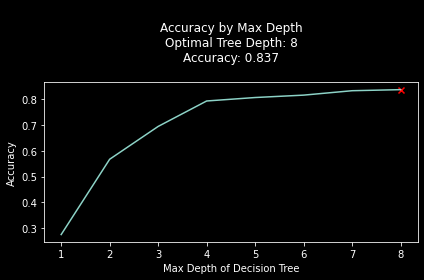

In [17]:
# plot of max depths
plt.plot(max_depth_list, accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker = 'x', color = 'red')

plt.title(f'''
Accuracy by Max Depth
Optimal Tree Depth: {optimal_depth}
Accuracy: {round(max_accuracy, 4)}
''')

plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [18]:
# re-train model with determined max depth
regressor_re_train = DecisionTreeRegressor(max_depth = 4) # less than the most accurate depth, attempt to keep decision tree smaller
regressor_re_train.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [19]:
# predict on the test set using re-trained model
y_pred_re_train = regressor_re_train.predict(X_test)
y_pred_re_train

array([0.408     , 0.5599    , 0.31028261, 0.31028261, 0.9198    ,
       0.31028261, 0.45915625, 0.24166667, 0.45915625, 0.82482222,
       0.31028261, 0.473     , 0.31028261, 0.68308333, 0.9198    ,
       0.73595   , 0.73595   , 0.82482222, 0.24166667, 0.31028261,
       0.82482222, 0.1097619 , 0.31028261, 0.1097619 , 0.82482222,
       0.73595   , 0.82482222, 0.68308333, 0.04310345, 0.45915625,
       0.68308333, 0.26666667, 0.473     , 0.04310345, 0.1097619 ,
       0.31028261, 0.5599    , 0.68308333, 0.9198    , 0.45915625,
       0.68308333, 0.45915625, 0.82482222, 0.473     , 0.1097619 ,
       0.9198    , 0.45915625, 0.54957143, 0.26666667, 0.5599    ,
       0.45915625, 0.82482222, 0.9198    , 0.9198    , 0.24166667,
       0.5599    , 0.26666667, 0.473     , 0.5599    , 0.82482222,
       0.82482222, 0.73595   , 0.45915625, 0.54957143, 0.68308333,
       0.68308333, 0.82482222, 0.68308333, 0.31028261, 0.68308333,
       0.82482222, 0.45915625, 0.45915625, 0.9198    , 0.9198 

In [20]:
# calculate new R-Squared
r_squared_re_train = r2_score(y_test, y_pred_re_train)
print(f'R-Squared = {r_squared_re_train}')

R-Squared = 0.7930266307432607


In [21]:
# calculate new adjusted r-squared
adjusted_r_squared_re_train = 1 - (1 - r_squared_re_train) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared_re_train}')

Adjusted R-Squared = 0.7693725313996334


R Squared and Adjusted R Squared dropped a few points due to the reduction of overfitting.

[Text(0.5, 0.9, 'distance_from_store <= 1.975\nsquared_error = 0.088\nsamples = 315\nvalue = 0.495'),
 Text(0.25, 0.7, 'distance_from_store <= 0.975\nsquared_error = 0.04\nsamples = 172\nvalue = 0.699'),
 Text(0.125, 0.5, 'total_sales <= 217.5\nsquared_error = 0.021\nsamples = 109\nvalue = 0.799'),
 Text(0.0625, 0.3, 'distance_from_store <= 0.62\nsquared_error = 0.018\nsamples = 34\nvalue = 0.659'),
 Text(0.03125, 0.1, 'squared_error = 0.012\nsamples = 20\nvalue = 0.736'),
 Text(0.09375, 0.1, 'squared_error = 0.006\nsamples = 14\nvalue = 0.55'),
 Text(0.1875, 0.3, 'distance_from_store <= 0.37\nsquared_error = 0.009\nsamples = 75\nvalue = 0.863'),
 Text(0.15625, 0.1, 'squared_error = 0.004\nsamples = 30\nvalue = 0.92'),
 Text(0.21875, 0.1, 'squared_error = 0.009\nsamples = 45\nvalue = 0.825'),
 Text(0.375, 0.5, 'credit_score <= 1680.295\nsquared_error = 0.026\nsamples = 63\nvalue = 0.525'),
 Text(0.3125, 0.3, 'credit_score <= 279.165\nsquared_error = 0.014\nsamples = 38\nvalue = 0.429')

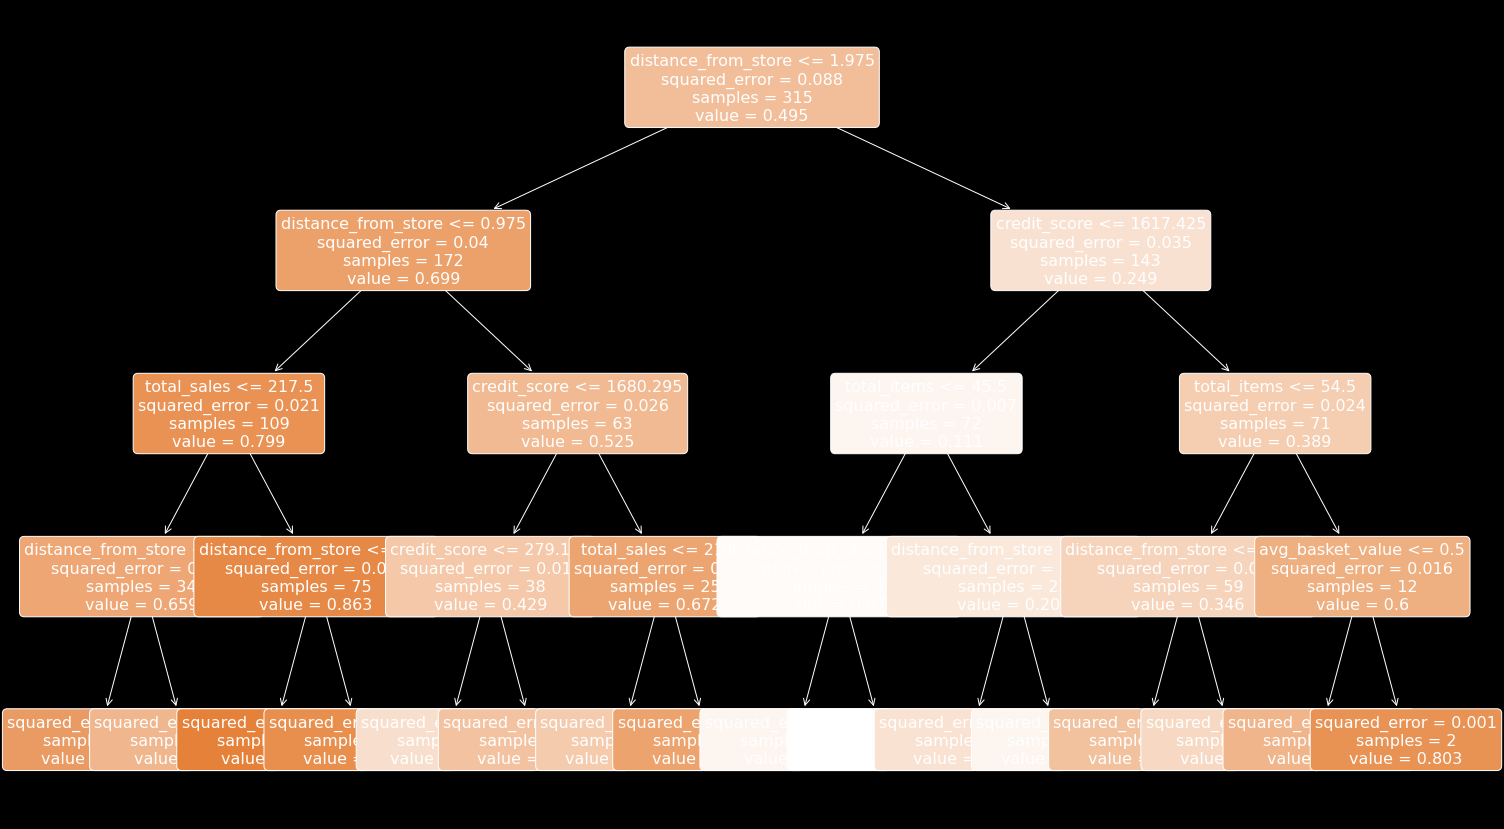

In [22]:
# plot decission tree
plt.figure(figsize = (25, 15))
tree = plot_tree(
    regressor_re_train,
    feature_names = X.columns,
    filled = True,
    rounded = True,
    fontsize = 16
)

tree